In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [2]:
df_news = pd.read_csv("../data/apple_2022/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/apple_2022/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [3]:
dfs = []
for i in range(1, 6):
    df_score = pd.read_csv(f"../data/apple_2022/news_score_apple_2022_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/apple_2022/news_score_apple_2022_all.csv")
df_score


# df_score = pd.read_csv(f"../data/apple_2022/news_score_apple_2022_{1}.csv", index_col=0)
# print(df_score.shape)
# df_score = df_score[["date", "score"]]
# df_score["date"] = pd.to_datetime(df_score['date'])

(439, 3)
(1096, 3)
(4000, 3)
(3200, 3)
(1800, 3)


,date,score
0,2022-01-01 00:32:44,0
1,2022-01-03 08:16:20,1
2,2022-01-03 15:35:48,-1
3,2022-01-04 05:49:27,1
4,2022-01-04 10:47:02,0
...,...,...
10530,2022-06-28 21:51:40,0
10531,2022-06-29 01:45:58,-1
10532,2022-06-29 04:46:26,-1
10533,2022-06-29 06:31:43,1


In [4]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-01 00:52:34,1
2,2022-01-01 01:04:02,0
3,2022-01-01 01:36:26,0
4,2022-01-01 07:26:01,1
...,...,...
10530,2022-12-29 20:16:15,0
10531,2022-12-30 07:02:20,1
10532,2022-12-30 16:50:34,-1
10533,2022-12-31 02:03:24,0


In [5]:
df_score["score"].value_counts()

 1    6386
 0    2284
-1    1860
 5       5
Name: score, dtype: int64

In [6]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [7]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [8]:
df_news.shape

(43832, 2)

In [9]:

columns = [f"price_in_{i}" for i in range(61)]
deltas = [2 * i for i in range(61)]
pd_price = np.zeros((df_news.shape[0], 61))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(61):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [10]:
date_price_dict

{Timestamp('2022-01-03 09:31:00'): 175.826575614,
 Timestamp('2022-01-03 09:32:00'): 176.596791996,
 Timestamp('2022-01-03 09:33:00'): 176.636290272,
 Timestamp('2022-01-03 09:34:00'): 176.7765091518,
 Timestamp('2022-01-03 09:35:00'): 176.705412255,
 Timestamp('2022-01-03 09:36:00'): 177.031273032,
 Timestamp('2022-01-03 09:37:00'): 177.386757516,
 Timestamp('2022-01-03 09:38:00'): 178.018729932,
 Timestamp('2022-01-03 09:39:00'): 177.890360535,
 Timestamp('2022-01-03 09:40:00'): 178.068102777,
 Timestamp('2022-01-03 09:41:00'): 177.969357087,
 Timestamp('2022-01-03 09:42:00'): 178.087851915,
 Timestamp('2022-01-03 09:43:00'): 178.275468726,
 Timestamp('2022-01-03 09:44:00'): 178.43346183,
 Timestamp('2022-01-03 09:45:00'): 178.33471614,
 Timestamp('2022-01-03 09:46:00'): 178.206346743,
 Timestamp('2022-01-03 09:47:00'): 178.127350191,
 Timestamp('2022-01-03 09:48:00'): 177.64349631,
 Timestamp('2022-01-03 09:49:00'): 177.525001482,
 Timestamp('2022-01-03 09:50:00'): 177.682994586,
 T

In [11]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [12]:
result_df

,date,news,price_in_0,price_in_1,price_in_2,price_in_3,price_in_4,price_in_5,price_in_6,price_in_7,...,price_in_51,price_in_52,price_in_53,price_in_54,price_in_55,price_in_56,price_in_57,price_in_58,price_in_59,price_in_60
0,2022-01-01 00:32:44,I actually lost weight this holiday season — t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-01 00:52:34,January Dogs Of The Dow Need A PullbackThirty-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-01 01:04:02,I switched from Android to iPhone — here's wha...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-01 01:36:26,"365 Inspirational Quotes for 2022Inspiring, po...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-01 02:06:21,Is Fitbit Premium worth it? Here's the pros an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43827,2022-12-31 19:01:02,The Fall Of Tesla And The Rise of Exxon Amid T...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43828,2022-12-31 21:34:25,Elon Musk becomes first person ever to lose $U...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43829,2022-12-31 21:36:15,Elon Musk becomes first person ever to lose $U...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43830,2022-12-31 23:02:20,I love my Kindle but I’m turning it off this s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-01 00:52:34,1
2,2022-01-01 01:04:02,0
3,2022-01-01 01:36:26,0
4,2022-01-01 07:26:01,1
...,...,...
10530,2022-12-29 20:16:15,0
10531,2022-12-30 07:02:20,1
10532,2022-12-30 16:50:34,-1
10533,2022-12-31 02:03:24,0


In [14]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = [f"return_in_{i}" for i in range(1,61)]
price_cols = [f"price_in_{i}" for i in range(61)]

for i in range(60):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_in_0"]) / result_df["price_in_0"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df = result_df.dropna()
result_df

,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
113,2022-01-03 09:39:53,Apple's wearable gadget business grew like gan...,1.0,0.0,0.000111,0.002052,0.000776,-0.002385,-0.002163,-0.002218,...,0.003494,0.003799,0.005324,0.006654,0.007431,0.007874,0.006987,0.006433,0.005490,0.005213
121,2022-01-03 10:04:28,My 3 Favorite ETFs to Own in 2022These three E...,1.0,0.0,0.001381,0.000828,0.001546,-0.000221,0.000828,-0.000110,...,0.002209,0.001933,0.002954,0.002706,0.003203,0.003120,0.002872,0.001905,0.001491,0.001546
122,2022-01-03 10:16:38,Wacom's One 13-inch drawing tablet upgrades yo...,1.0,0.0,-0.000221,-0.002320,-0.002458,-0.001933,-0.001105,-0.000718,...,0.002982,0.002016,0.001602,0.001657,0.002209,0.001574,0.000939,0.001602,0.000746,0.001270
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,1.0,0.0,0.000526,0.001356,0.001744,0.000581,0.001301,0.001966,...,0.004125,0.004678,0.004042,0.003405,0.004069,0.003211,0.003737,0.004125,0.004623,0.005066
132,2022-01-03 11:13:34,Roblox And The Sentiment MonsterThe price acti...,0.0,0.0,-0.000940,-0.000111,0.000442,0.000746,0.002267,0.003594,...,0.004810,0.005142,0.005390,0.004478,0.004644,0.004810,0.005639,0.005529,0.005307,0.005639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43041,2022-12-22 10:37:25,SPY And QQQ: Sleighin' Or Getting Slayed?Lofty...,1.0,0.0,-0.001369,0.000456,0.000913,-0.000228,0.001978,0.003195,...,0.000761,0.000571,-0.001293,-0.002435,-0.003956,-0.004337,-0.005021,-0.004717,-0.005326,-0.004831
43361,2022-12-27 11:18:45,Charter's (CHTR) Slow Internet Customer Growth...,-1.0,0.0,-0.001468,-0.001081,0.002240,0.001081,0.002240,0.002781,...,0.005098,0.005484,0.006257,0.005948,0.006102,0.006566,0.006257,0.005639,0.005639,0.005253
43481,2022-12-28 11:37:34,Netflix's (NFLX) Glass Onion Hits the Right Ch...,1.0,0.0,0.000944,0.000629,-0.000157,-0.000079,-0.001967,-0.003541,...,0.005193,0.005507,0.003541,0.002203,0.002282,0.002832,0.002596,0.000472,0.000787,0.000787
43500,2022-12-28 13:18:25,"Stocks making the biggest moves midday: Tesla,...",0.0,0.0,-0.001173,-0.002347,-0.003286,-0.002738,-0.003520,-0.003755,...,-0.007588,-0.008175,-0.009857,-0.009387,-0.009622,-0.010404,-0.011030,-0.012908,-0.014159,-0.012517


In [15]:
result_df = result_df.dropna()

In [16]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_50233/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
count,2568,2568,2568.000000,2568.0,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,...,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000,2568.000000
unique,2566,2550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-11-14 11:02:40,"OWC To Showcase Latest Storage, Connectivity a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:39:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-29 12:08:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.507788,0.0,-0.000016,0.000041,0.000024,0.000017,0.000038,0.000045,...,-0.000137,-0.000141,-0.000152,-0.000139,-0.000148,-0.000157,-0.000144,-0.000145,-0.000127,-0.000150
std,NaN,NaN,0.752568,0.0,0.001303,0.001891,0.002260,0.002609,0.002869,0.003224,...,0.007673,0.007730,0.007786,0.007883,0.007977,0.008021,0.008076,0.008139,0.008193,0.008268
min,NaN,NaN,-1.000000,0.0,-0.007494,-0.011936,-0.014049,-0.017092,-0.018673,-0.020085,...,-0.029855,-0.028385,-0.029196,-0.032505,-0.033357,-0.035061,-0.036929,-0.035906,-0.037148,-0.038587
25%,NaN,NaN,0.000000,0.0,-0.000708,-0.000911,-0.001110,-0.001352,-0.001480,-0.001638,...,-0.004666,-0.004823,-0.004853,-0.004922,-0.004985,-0.004947,-0.004850,-0.004882,-0.004966,-0.004909


In [17]:
result_df[result_df['score'] == i][f"return_in_{j}"].mean()

nan

In [18]:
# import seaborn as sns
# for return_col in ['return_in_5', 'return_in_10', 'return_in_20', 'return_in_60']:
#     sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
#     plt.title(f'Score vs {return_col}')
#     plt.show()

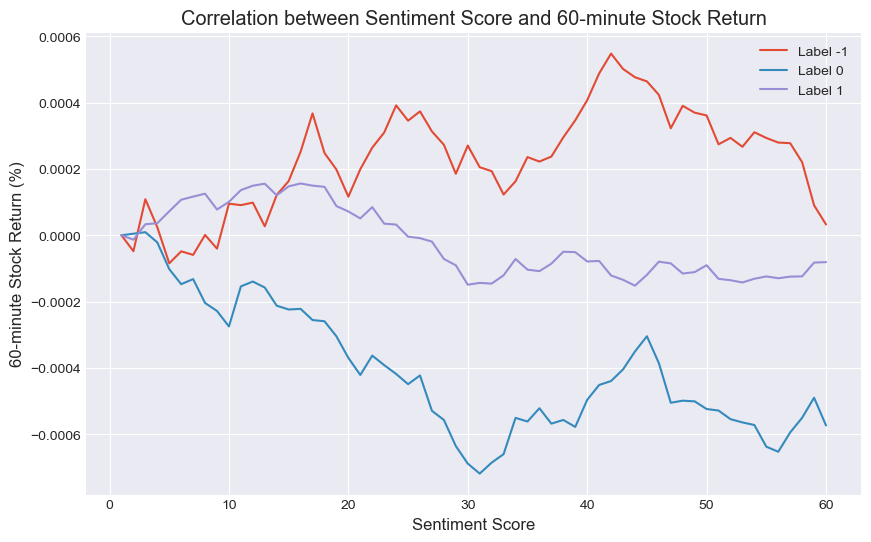

In [21]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size as needed

plt.style.use('seaborn-v0_8-darkgrid')

for i in [-1, 0, 1]:
    arr = []
    for j in range(1, 61):
        avg_return = result_df[result_df['score'] == i][f"return_in_{j}"].mean()
        arr.append(avg_return)
    plt.plot(list(range(1,61)), arr, label=f'Label {i}')
    
plt.title('Correlation between Sentiment Score and 60-minute Stock Return')
plt.xlabel('Time (Minute)')
plt.ylabel('Stock Return (%)')


plt.legend()
plt.grid(True)
plt.show()
    

In [20]:

for j in [-1, 0, 1]:
    print(f"When score is {j}, the mean return is {result_df[result_df['score'] == j]['return_in_60'].mean()*10000}")
    

When score is -1, the mean return is 0.3253850322629013
When score is 0, the mean return is -5.733263250613055
When score is 1, the mean return is -0.80940661534486
